# Model Selection

## Packages

We begin by loading in necessary software packages, introducing options for saving the results, and software for computing PSIS LOO in Python.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import netCDF4 as nc4
import numpy as np
import pandas as pd
import logging

import pystan
import re
import time

In [2]:
# use test data (not all data is used for fitting/training)
use_testdata = False

# create plots of the data
show_data = True

# netCDF output file (set to None to not save output)
savename_output = '../results/zinser_results_full.nc'

# save the Stan output instead a few stats (only active if filename is specified above)
save_stan_output = True

# specify the Stan variable names to save; if set to None, all variables are saved 
# (only active if save_stan_output is True)
varnames_save = None

# the number of tries to fit each Stan model to achieve an R-hat < 1.1
num_tries = 3

# the number of chains to run
num_chains = 6

# the prior_only option passed to each Stan model
prior_only = False

## Load, Plot Data

In [3]:
# load data
datafiles = {
    'zinser':'data/Zinser_SizeDist_logtransform-25-7.nc',
}

# Indices of data to hold out for cross validation
itestfiles = {
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'zinser':'Zinser dataset',    
}

size_units = 'fg C cell$^{-1}$'

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]

    # create "counts" entry
    if 'count' in data_gridded[dataname]:
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['count'][None,:] * data_gridded[dataname]['w_obs']).astype(int)
    elif 'abundance' in data_gridded[dataname]:
        logging.warning('{}: Using "abundance" data to generate count data for the model.'.format(dataname))
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['count'][None,:] * data_gridded[dataname]['w_obs']).astype(int)
    else:
        raise RuntimeError('Cannot find a "count" or "abundance" entry in "{}".'.format(datafiles[dataname]))
        
    
    # add description
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

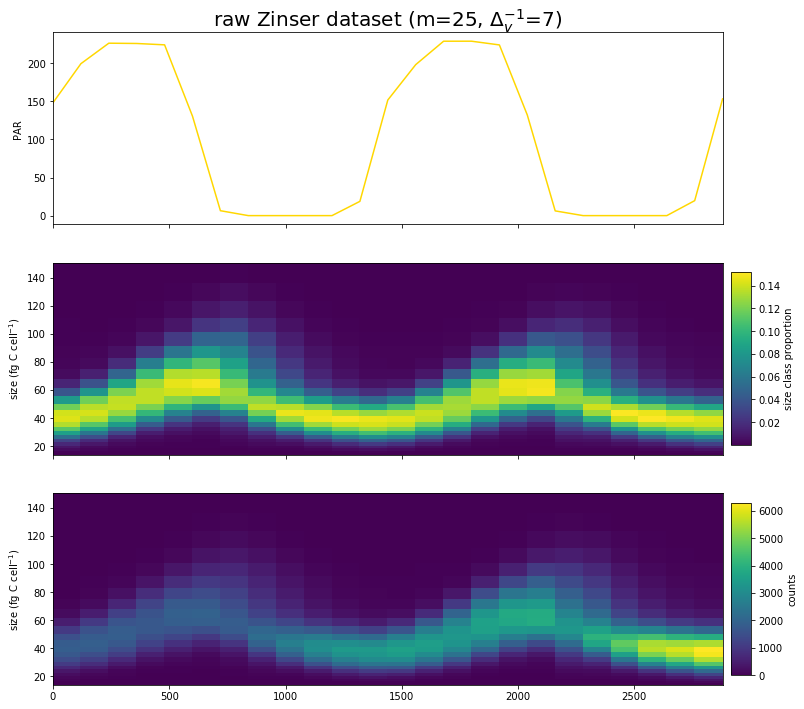

In [4]:
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if show_data:
    for i,dataname in enumerate(data_gridded):
        nrows = 3

        v_min = data_gridded[dataname]['v_min']
        delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 

        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('raw '+desc[dataname], size=20)
        ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
        ax.set(ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['w_obs'], shading='auto')
        ax.set(ylabel='size ({})'.format(size_units))
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['counts'], shading='auto')
        ax.set(ylabel='size ({})'.format(size_units))
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    axs[-1].set_xlabel=('time (minutes)')
None

## Process and Re-plot Data

In [5]:
# prepare data for Stan model

seaflow_filter_par = False

if 'data' not in globals():
    data = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = None
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        if limit_days is None:
            limit_days = int(np.ceil(data[dataname]['t_obs'][-1]/1440))
        
        if seaflow_filter_par:
            # median filter PAR
            # see: medianfilter_par.ipynb
            n = len(data_gridded[dataname]['PAR'])
            wsh = 30 # half of median filter window size; window size is 2*wsh+1
            par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
        else:
            par = data_gridded[dataname]['PAR']
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        
        if not np.all(ind_obs):
            print('{}: limit_days is set to {}, removing {}/{} observation times'.format(dataname, limit_days, ind_obs.size-np.count_nonzero(ind_obs), ind_obs.size))
        
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    if use_testdata:
        # load cross-validation testing indices and add them to data
        data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
        # remove last index, so that dimensions agree
        data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    else:
        # set all indices to zero
        data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
        
    # switch on or off data fitting
    data[dataname]['prior_only'] = int(prior_only)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

zinser: limit_days is set to 2, removing 1/25 observation times


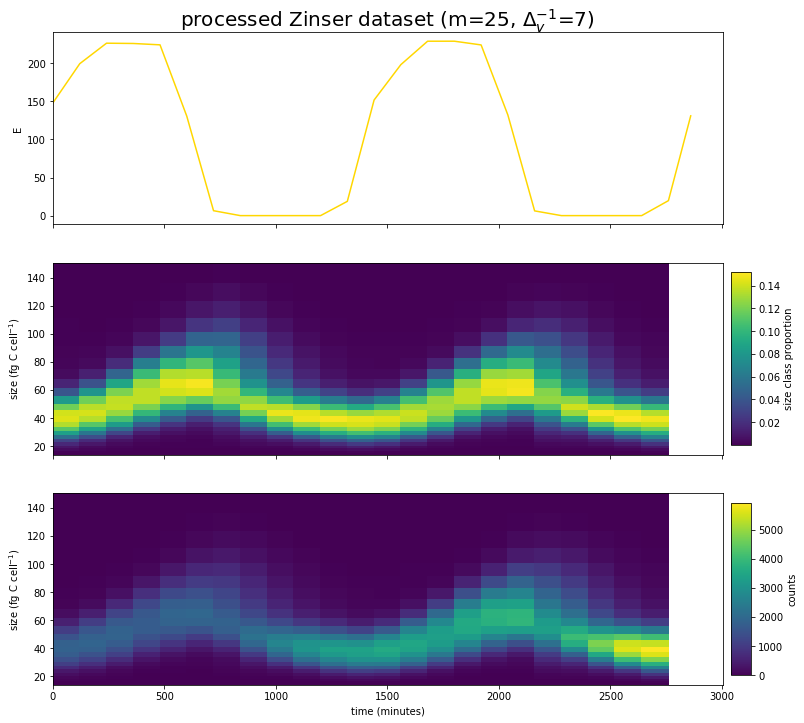

In [6]:
if show_data:
    for i,dataname in enumerate(data):
        nrows = 3

        v_min = data[dataname]['v_min']
        delta_v = 1.0/data[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
        t = np.arange(data[dataname]['nt'])*data[dataname]['dt']


        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('processed '+desc[dataname], size=20)
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(ylabel='E')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, data[dataname]['obs'], shading='auto')
        ax.set(ylabel='size ({})'.format(size_units))
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
        ax.set_xlim(left=0.0)

        ax = axs[2]
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, data[dataname]['obs_count'], shading='auto')
        ax.set(ylabel='size ({})'.format(size_units))
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
        ax.set_xlim(left=0.0)
    axs[-1].set_xlabel('time (minutes)')
None

## Choose models to fit

In [7]:
# desc_model = {
#     #'m1':'m1',
#     'm2':'m2',
#     #'m3':'m3',
#     'm4':'m4',
#     #'m5':'m5',
#     #'m6':'m6',
#     #'m7':'m7',
#     #'m8':'m8',
#     #'m9':'m9',
#     #'m10':'m10',
#     #'m11':'m11',
#     #'m12':'m12',
#     #'m13':'m13',
#     #'m14':'m14',
#     #'m3u':'m3u',
#     #'m6u':'m6u',
#     #'m7u':'m7u',
#     #'m8u':'m8u',
#     #'m9u':'m9u',
#     #'m11u':'m11u',
#     'm12u':'m12u',
#     #'m13u':'m13u',
#     #'m14u':'m14u',
#     'm15':'m15',
#     'm16':'m16',
#     'm4s6':'m4 + spline6',
#     'm12us6':'m12u + spline6',
#     'm15s6':'m15 + spline6',
#     'm16s6':'m16 + spline6',
# }
# # preparing for some regular expression magic
# model_code_replacements = {
#     'm1':(),
#     'm2':(),
#     'm3':(),
#     'm4':(),
#     'm5':(),
#     'm6':(),
#     'm7':(),
#     'm8':(),
#     'm9':(),
#     'm10':(),
#     'm11':(),
#     'm12':(),
#     'm13':(),
#     'm14':(),
#     'm3u':(),
#     'm6u':(),
#     'm7u':(),
#     'm8u':(),
#     'm9u':(),
#     'm11u':(),
#     'm12u':(),
#     'm13u':(),
#     'm14u':(),
#     'm15':(),
#     'm16':(),
#     'm4s6':(('^( *int nknots = *)','6;'),),
#     'm12us6':(('^( *int nknots = *)','6;'),),
#     'm15s6':(('^( *int nknots = *)','6;'),),
#     'm16s6':(('^( *int nknots = *)','6;'),),
# }
# model_stan_key = {
#     'm1':'c1',
#     'm2':'c2',
#     'm3':'c3',
#     'm4':'c4',
#     'm5':'c5',
#     'm6':'c6',
#     'm7':'c7',
#     'm8':'c8',
#     'm9':'c9',
#     'm10':'c10',
#     'm11':'c11',
#     'm12':'c12',
#     'm13':'c13',
#     'm14':'c14',
#     'm3u':'c3u',
#     'm6u':'c6u',
#     'm7u':'c7u',
#     'm8u':'c8u',
#     'm9u':'c9u',
#     'm11u':'c11u',
#     'm12u':'c12u',
#     'm13u':'c13u',
#     'm14u':'c14u',
#     'm15':'c15',
#     'm16':'c16',
#     'm4s6':'c4s',
#     'm12us6':'c12us',
#     'm15s6':'c15s',
#     'm16s6':'c16s',
# }

# Convert dictionary keys to model keys
model_dict = {
    'm2': 'm_bmx',
    'm4': 'm_bmb',
    'm12u': 'm_pmb',
    'm15': 'm_fmb',
    'm16': 'm_fmf',
    'm4s6': 'm_btb',
    'm12us6': 'm_ptb',
    'm15s6': 'm_ftb',
    'm16s6': 'm_ftf',
}

reverse_dict = {}
for key in model_dict:
    reverse_dict[model_dict[key]] = key

# Convert model keys to model names
desc_model = {
    'm_bmx': 'm$_\mathrm{bmx}$',
    'm_bmb': 'm$_\mathrm{bmb}$',
    'm_pmb': 'm$_\mathrm{pmb}$',
    'm_fmb': 'm$_\mathrm{fmb}$',
    'm_fmf': 'm$_\mathrm{fmf}$',
    'm_btb': 'm$_\mathrm{btb}$', 
    'm_ptb': 'm$_\mathrm{ptb}$', 
    'm_ftb': 'm$_\mathrm{ftb}$',
    'm_ftf': 'm$_\mathrm{ftf}$',
}

# Code files
stan_files = {
    'm_bmx': '../stan_code/m_bmx.stan',
    'm_bmb': '../stan_code/m_bmb.stan',
    'm_pmb': '../stan_code/m_pmb.stan',
    'm_fmb': '../stan_code/m_fmb.stan',
    'm_fmf': '../stan_code/m_fmf.stan',
    'm_btb': '../stan_code/m_btb.stan',
    'm_ptb': '../stan_code/m_ptb.stan',
    'm_ftb': '../stan_code/m_ftb.stan',
    'm_ftf': '../stan_code/m_ftf.stan',
}

## Fit Models to the Data

In [8]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'models' not in globals():
    models = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'maxrhats' not in globals():
    maxrhats = {}
if 'sampling_time' not in globals():
    sampling_time = {}
if 'num_tries' not in globals():
    num_tries = 3
    
try_again = True
refit_all = False

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for model in desc_model:
    code_split = stan_base_code[model_stan_key[model]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[model]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(model, line_new))
        code_split_new.append(line_new)
                
    stan_code[model] = '\n'.join(code_split_new)

m4s6: patching in "    int nknots = 6;"
m12us6: patching in "    int nknots = 6;"
m15s6: patching in "    int nknots = 6;"
m16s6: patching in "    int nknots = 6;"


In [9]:
for model in desc_model:
    refit_required[model] = True
    if model in models and models[model].model_code == stan_code[model]:
        print('{}: unchanged code, not recompiling'.format(model))
        refit_required[model] = False
    else:
        if model in models:
            print('{}: code change detected, recompiling'.format(model))
        else:
            print('{}: compiling'.format(model))
        models[model] = pystan.StanModel(model_code=stan_code[model], model_name=model, obfuscate_model_name=False)

# run a bunch of experiments -- this may take a while
for model in models:
    if model not in maxrhats:
        maxrhats[model] = {}
    if model not in sampling_time:
        sampling_time[model] = {}
    for dataname in data:
        if dataname not in maxrhats[model]:
            maxrhats[model][dataname] = []
        if dataname not in sampling_time[model]:
            sampling_time[model][dataname] = []
        if model in mcmcs:
            if dataname in mcmcs[model] and not refit_all and not refit_required[model]:
                print('{}: found existing results:'.format(model))
                print('{} ({})'.format(model, desc_model[model])) 
                print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if '[' not in x))
                rhat_max = get_max_rhat(mcmcs[model][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(model,rhat_max))
                else:
                    print('{}: not re-running model'.format(model))
                    print()
                    continue
            elif refit_all:
                print('{}: refit_all is active, re-running model'.format(model))
            elif refit_required[model]:
                print('{}: change in model code requires re-running model'.format(model))
        else:
            mcmcs[model] = {}
        for itry in range(num_tries):
            t0 = time.time()
            mcmcs[model][dataname] = models[model].sampling(data=data[dataname], iter=2000, chains=num_chains)
            sampling_time[model][dataname].append(time.time() - t0) # in seconds
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[model][dataname])
            maxrhats[model][dataname].append(rhat_max)
            print('{}: in try {}/{} found Rhat={:.3f}'.format(model, itry+1, num_tries, rhat_max), end='')
            if rhat_max < 1.1 or itry == num_tries - 1:
                print()
                break
            print(', trying again')
        
        print('{} ({})'.format(model, desc_model[model])) 
        print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if '[' not in x))
        print()

m2: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m2 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m4 NOW.


m4: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m12u NOW.


m12u: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m15 NOW.


m15: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m16 NOW.


m16: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m4s6 NOW.


m4s6: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m12us6 NOW.


m12us6: compiling
m15s6: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m15s6 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL m16s6 NOW.


m16s6: compiling


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m2: in try 1/3 found Rhat=1.003
m2 (m2)
Inference for Stan model: m2.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              40.15     0.2   9.61  25.43   33.1  38.73  45.66   63.0   2333    1.0
gamma_max               6.89  7.6e-3   0.51    5.6   6.61   7.03    7.3   7.47   4574    1.0
rho_max                 3.71    0.02   2.14    0.2   1.84    3.7   5.56   7.28  13365    1.0
E_star                478.54    0.73   51.9 360.02 446.94 483.94 515.07 566.07   5012    1.0
sigma                 163.59    0.09   9.54 145.04  157.2 163.51 170.02 182.47  11833    1.0
divrate                 1.08  6.0e-4   0.05   0.98   1.04   1.07   1.11   1.17   6787    1.0
lp__                  -1.4e6     0.4  18.01 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2065    1.0

Samples were drawn using NUTS at Wed Dec 23 11:50:59 2020.
For each

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m4: in try 1/3 found Rhat=1.002
m4 (m4)
Inference for Stan model: m4.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              59.59     0.1   7.66  43.45  54.17  60.37  65.79  71.17   6245    1.0
gamma_max               7.01  7.2e-3   0.41   5.99   6.79   7.12   7.34   7.48   3248    1.0
rho_max                 0.79  3.9e-4   0.03   0.73   0.77   0.79   0.81   0.85   5989    1.0
E_star                326.01    0.51   29.3 257.28  309.8 331.19 346.65  371.4   3315    1.0
sigma                 303.84     0.2  17.39 270.76 291.82  303.5 315.29 339.34   7564    1.0
divrate                 0.68  3.3e-4   0.03   0.63   0.66   0.68    0.7   0.73   6092    1.0
lp__                  -1.4e6    0.39  18.14 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2152    1.0

Samples were drawn using NUTS at Wed Dec 23 12:10:59 2020.
For each

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m12u: in try 1/3 found Rhat=1.005
m12u (m12u)
Inference for Stan model: m12u.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              11.22    0.06   3.11   6.83   9.01  10.67  12.74  18.96   3099    1.0
gamma_max               7.45  4.7e-4   0.05   7.32   7.43   7.46   7.48   7.49  10244    1.0
rho_max                 1.05  3.8e-4   0.03   0.99   1.03   1.05   1.07   1.11   6013    1.0
E_star                 94.51    0.12   8.36  79.12  88.74  94.19 100.15 111.36   5125    1.0
sigma                 460.63    0.27  25.83 410.68  442.7  460.2 478.22 512.71   9251    1.0
exponent_gamma         -0.66  3.1e-4   0.02   -0.7  -0.68  -0.66  -0.65  -0.61   5483    1.0
divrate                 0.34  2.6e-4   0.02    0.3   0.33   0.34   0.35   0.38   5554    1.0
lp__                  -1.4e6    0.39  18.18 -1.4e6 -1.4e6 -1

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m15: in try 1/3 found Rhat=9.965, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m15: in try 2/3 found Rhat=1.004
m15 (m15)
Inference for Stan model: m15.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               5.06    0.01   0.93   3.74   4.43    4.9   5.49   7.32   4480    1.0
gamma_mu                4.41  5.5e-3   0.49   3.44   4.09   4.42   4.74   5.37   8012    1.0
gamma_sigma             2.26  4.0e-3   0.37   1.66   2.01   2.22   2.48    3.1   8297    1.0
rho_max                 1.06  3.7e-4   0.03   1.01   1.04   1.06   1.08   1.12   5870    1.0
E_star                141.35    0.26  12.57 117.42  132.7 141.16 149.73 165.95   2377    1.0
sigma                 565.39     0.3  32.91 502.98  542.2 564.96 587.33 631.54  12268    1.0
divrate                 0.29  2.2e-4   0.02   0.26   0.28   0.29    0.3   0.33   6291    1.0
lp__                  -1.4e6     0.4  18.66 -1.4e6 -1.4e6 -1.4e6

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m16: in try 1/3 found Rhat=1.005
m16 (m16)
Inference for Stan model: m16.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max                0.6  3.2e-3   0.19   0.31   0.46   0.57   0.71   1.07   3779    1.0
gamma_mu                5.27  7.5e-3   0.49   4.31   4.95   5.27   5.58   6.24   4194    1.0
gamma_sigma             2.17  5.3e-3   0.38   1.57    1.9   2.13   2.38   3.04   5084    1.0
rho_mu                  1.18  1.9e-3   0.14   0.92   1.09   1.17   1.27   1.46   5093    1.0
rho_sigma               0.61  2.0e-3   0.12   0.42   0.52   0.59   0.68   0.91   3909    1.0
E_star                256.19    0.35  13.37 227.25 247.87 257.32  265.6 279.98   1466    1.0
sigma                 1364.9    1.16  86.09 1205.1 1304.1 1363.5 1422.2 1541.1   5543    1.0
divrate                 0.09  2.1e-4   0.01   0.07   0.08   0.09

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m4s6: in try 1/3 found Rhat=1.002
m4s6 (m4 + spline6)
Inference for Stan model: m4s6.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              71.03    0.01   0.97  68.36  70.66  71.34  71.72  71.98   9378    1.0
gamma_max               7.14  4.7e-3   0.32   6.31   6.99   7.23   7.38   7.49   4433    1.0
rho_max                 0.63  1.2e-3   0.06   0.49   0.59   0.63   0.67   0.74   2625    1.0
E_star                322.13    0.49  27.62 265.43 304.83 322.99 339.57  376.1   3234    1.0
sigma                 454.53    0.29  26.41  404.8 436.28 454.09 472.61 507.17   8353    1.0
divrate                 0.91  4.6e-4   0.04   0.83   0.88   0.91   0.94   0.99   7972    1.0
lp__                  -1.4e6    0.36  17.98 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2441    1.0

Samples were drawn using NUTS at Wed Dec 23 15:13:3

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m12us6: in try 1/3 found Rhat=1.006
m12us6 (m12u + spline6)
Inference for Stan model: m12us6.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              57.16    0.19   7.85  42.35  51.35  57.01  63.25  71.02   1627    1.0
gamma_max               7.32  1.8e-3   0.16   6.91   7.25   7.37   7.44   7.49   7080    1.0
rho_max               5.4e-3  5.9e-5 5.6e-3 1.2e-4 1.5e-3 3.7e-3 7.4e-3   0.02   8821    1.0
E_star                176.82    0.18  13.64 150.61 167.78 176.42 185.86 204.18   5651    1.0
sigma                 1346.8    0.99  79.57 1194.8 1292.6 1345.3 1400.6 1504.1   6486    1.0
exponent_gamma         -0.78  3.1e-4   0.02  -0.83   -0.8  -0.78  -0.77  -0.73   5730    1.0
divrate                 0.95  2.0e-4   0.02   0.92   0.94   0.95   0.96   0.99   7002    1.0
lp__                  -1.4e6    0.42  18.15 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m15s6: in try 1/3 found Rhat=1.012
m15s6 (m15 + spline6)
Inference for Stan model: m15s6.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              37.93    0.18    6.1  29.26  33.66  36.84  41.06  53.25   1174    1.0
gamma_mu                4.28    0.01   0.52   3.27   3.94   4.28   4.63   5.31   2138    1.0
gamma_sigma             2.12  5.7e-3   0.37   1.52   1.86   2.08   2.33   2.95   4038    1.0
rho_max                 0.04  3.8e-4   0.03 2.2e-3   0.02   0.04   0.06   0.11   5712    1.0
E_star                328.01    1.36  30.16 261.95 309.82  329.9 348.89 382.51    494   1.01
sigma                 1667.7    1.17 102.04 1471.9 1596.8 1665.8 1736.5 1868.7   7575    1.0
divrate                 0.91  3.3e-4   0.02   0.86   0.89   0.91   0.93   0.96   5685    1.0
lp__                  -1.4e6    0.41  18.92 -1.4

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m16s6: in try 1/3 found Rhat=1.007
m16s6 (m16 + spline6)
Inference for Stan model: m16s6.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              17.56    0.05   2.61  13.78  15.77  17.14  18.83  23.75   2940    1.0
gamma_mu                4.82  7.3e-3   0.52    3.8   4.48   4.81   5.17   5.84   5031    1.0
gamma_sigma             2.39  5.0e-3   0.39   1.75    2.1   2.34   2.62   3.27   6041    1.0
rho_mu                  0.43  1.2e-3   0.07   0.29   0.38   0.43   0.48   0.58   3922    1.0
rho_sigma               0.31  8.0e-4   0.06   0.22   0.27   0.31   0.34   0.44   5012    1.0
E_star                350.08    0.53  16.62 314.16 339.91 351.32 361.58 378.88    993   1.01
sigma                 3605.6    4.06 263.39 3114.9 3422.4 3594.6 3777.6 4145.6   4208    1.0
divrate                 0.49  5.1e-4   0.02   0.

## Save Results

In [10]:
if 'varnames_save' not in globals():
    varnames_save = None

save_only_converged = True

if savename_output is not None:    
    with nc4.Dataset(savename_output, 'w') as nc:
        for dataname in data:
            ncg = nc.createGroup(dataname)

            if save_stan_output:
                dimensions = {
                    'obstime':int(data[dataname]['nt_obs']),
                    'time':int(data[dataname]['nt']),
                    'sizeclass':int(data[dataname]['m']),
                    'm_minus_j_plus_1':int(data[dataname]['m']-data[dataname]['delta_v_inv']),
                    'm_minus_1':int(data[dataname]['m']-1),
                    'knots_minus_1':int(6-1),
                }
                dimensions_inv = {v:k for k,v in dimensions.items()}
                for d in dimensions:
                    ncg.createDimension(d, dimensions[d])
                    
                ncg.createVariable('time', int, ('time',))
                ncg.variables['time'][:] = int(data[dataname]['dt']) * np.arange(data[dataname]['nt'])
                ncg.variables['time'].units = 'minutes since start of experiment'
                
                ncg.createVariable('obstime', int, ('obstime',))
                ncg.variables['obstime'][:] = data[dataname]['t_obs'].astype(int)
                ncg.variables['obstime'].units = 'minutes since start of experiment'
                ncg.variables['obstime'].long_name = 'time of observations'

                for v in ('dt', 'm', 'v_min', 'delta_v_inv', 'obs', 'i_test', 'E', 'obs_count'):
                    if isinstance(data[dataname][v], int):
                        ncg.createVariable(v, int, zlib=True)
                        ncg.variables[v][:] = data[dataname][v]
                    elif isinstance(data[dataname][v], float):
                        ncg.createVariable(v, float, zlib=True)
                        ncg.variables[v][:] = data[dataname][v]
                    else:
                        dims = tuple(dimensions_inv[d] for d in data[dataname][v].shape)
                        ncg.createVariable(v, data[dataname][v].dtype, dims, zlib=True)
                        ncg.variables[v][:] = data[dataname][v]
                
                for imodel,model in enumerate(mcmcs):
                    if save_only_converged and get_max_rhat(mcmcs[model][dataname]) > 1.1:
                        logging.warning('Model "{}" did not converge -- skipping.'.format(model))
                        continue
                    ncm = ncg.createGroup(model)
                    
                    dimensions['sample'] = mcmcs[model][dataname]['mod_obspos'].shape[0]
                    dimensions_inv[dimensions['sample']] = 'sample'
                    ncm.createDimension('sample', dimensions['sample'])
                    if 'tau[1]' in mcmcs[model][dataname].flatnames:
                        dimensions['tau'] = mcmcs[model][dataname]['tau'].shape[1]
                        dimensions_inv[dimensions['tau']] = 'tau'
                        ncm.createDimension('tau', dimensions['tau'])
                    
                    # write model description
                    ncm.setncattr('description', desc_model[model])
                    ncm.setncattr('code', stan_files[model_stan_key[model]])
                    
                    varnames = set(v.split('[')[0] for v in mcmcs[model][dataname].flatnames)
                    varnames.add('lp__')
                    if varnames_save is None:
                        varnames_curr = varnames
                    else:
                        varnames_curr = varnames_save
                        
                    for v in varnames_curr:
                        if v in varnames:
                            dims = tuple(dimensions_inv[d] for d in mcmcs[model][dataname][v].shape)
                            ncm.createVariable(v, float, dims, zlib=True)
                            ncm.variables[v][:] = mcmcs[model][dataname][v]
                        else:
                            logging.warning('Cannot find variable "{}" for model "{}".'.format(v, model))
            else:
                for i,model in enumerate(mcmcs):
                    if i == 0:
                        ncg.createDimension('model', len(mcmcs))
                        ncg.createDimension('sample', mcmcs[model][dataname]['divrate'].shape[0])

                        ncg.createVariable('divrate', float, ('model','sample'))
                        ncg.createVariable('sumsqdiff', float, ('model','sample'))
                        ncg.variables['sumsqdiff'].setncattr('long_name', 'sum of squared column differences')

                    ncg.variables['divrate'][i,:] = mcmcs[model][dataname]['divrate']

                    obs = data[dataname]['obs']

                    tmp = mcmcs[model][dataname]['mod_obspos']
                    tmp/= np.sum(tmp, axis=1)[:,None,:]
                    tmp -= obs[None,:,:]
                    tmp **= 2

                    if np.all(data[dataname]['i_test'] == 0):
                        ncg.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp, axis=1), axis=1)
                        if i == 0:
                            ncg.variables['sumsqdiff'].setncattr('data_used', 'all data')
                    else:
                        nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                        if i == 0:
                            ncg.variables['sumsqdiff'].setncattr('data_used', 'testing data')

                    for iv,v in enumerate(('gamma_max','rho_max','xi','xir','E_star')):
                        if i == 0:
                            ncg.createVariable(v, float, ('model','sample'))
                        if v in mcmcs[model][dataname].flatnames:
                            ncg.variables[v][i,:] = mcmcs[model][dataname][v]